In [2]:
from statistics import mode
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from preprocess.VoiceBankDEMAND import VoiceBandDEMAND
from preprocess.feature_extractor import FeatureExtractor
from utils import prepare_input_features, read_audio, load_yaml

# Load the TensorBoard notebook extension.
# %load_ext tensorboard

from tensorflow.python.client import device_lib
import keras.models

# SHOULD PUT model path
model_path = Path(f'./result/cnn/20221102-133648/')
path_conf = os.path.join(model_path, "config.yaml")
args = load_yaml(path_conf)

Found GPU at: /device:GPU:0Metal device set to: 
Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-02 13:41:04.797012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 13:41:04.797137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# 1. Set Paramter
device_lib.list_local_devices()
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

model_name = args.model.name
domain = args.dset.domain
nfft = args.dset.n_fft
win_length = args.dset.win_length
hop_length = args.dset.hop_length
center = args.dset.center
num_feature = args.dset.n_feature
num_segment = args.dset.n_segment
sample_rate = args.dset.sample_rate
center = args.dset.center

# 2. Load data
if args.dset.top_db > args.dset.max_db: # 16bit
    path_to_dataset = f"{args.dset.save_path}_{args.model.name}_{args.dset.domain}"
else:
    path_to_dataset = f"{args.dset.save_path}_{args.model.name}_{args.dset.domain}_{args.dset.top_db}topdb"

print("Data path: ", path_to_dataset)

# 3. Build model
if model_name == "cnn":
    from model.cnn import build_model
    model = build_model(l2_strength=0.0, args=args)
elif model_name == "lstm":
    from model.lstm import build_model_lstm
    model = build_model_lstm(args)
else:
    raise ValueError("Model didn't implement...")
model.summary()

Data path:  ./preprocess/data_cnn_freq


2022-11-02 13:41:09.455633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 13:41:09.455657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-02 13:41:09.465236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 13:41:09.465259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 129, 8, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 129, 1, 18)   1296        ['zero_padding2d[0][0]']         
                                                                                                  
 activation (Activation)        (None, 129, 1, 18)   0           ['conv2d[0][0]']                 
                                                                                              

In [4]:
# Model load
model = keras.models.load_model(model_path / "model")

In [8]:
dataset_path = args.dset.wav

dataset_voicebank = VoiceBandDEMAND(dataset_path, val_dataset_percent=0.3)
clean_test_filenames, noisy_test_filenames = dataset_voicebank.get_test_filenames()

# SHOULD select file
clean_file = clean_test_filenames[5] 
noisy_file = noisy_test_filenames[5]

# clean_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/clean.wav"
# noisy_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/dirty.wav"

print("Clean: ", clean_file)
print("Noisy: ", noisy_file)

cleanAudio, sr = read_audio(clean_file, sample_rate)
noisyAudio, sr = read_audio(noisy_file, sample_rate)

cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=win_length, overlap=hop_length, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram(center)
stft_features = np.abs(stft_features)

print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=win_length, overlap=hop_length, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram(center)

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

File example:
Clean:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_001.wav The number:  824
Noisy:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_001.wav The number:  824
# of Noise testing files: 824
Clean:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_170.wav
Noisy:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_170.wav
Min: 4.7811805e-06 Max: 8.01346


In [10]:
if model_name == "cnn":
    predictors = prepare_input_features(noise_stft_features, num_segment, num_feature)

    predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
    predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
    print('predictors.shape:', predictors.shape)

    STFTFullyConvolutional = model.predict(predictors)
    print(STFTFullyConvolutional.shape)

elif model_name == "lstm":
  predictors = prepare_input_features(noise_stft_features, num_segment, num_feature)
  predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], predictors.shape[2]))
  predictors = np.transpose(predictors, (2, 0, 1)).astype(np.float32)
  predictors = np.transpose(predictors, (0, 2, 1))
  predictors = np.expand_dims(predictors, axis=1)

  STFTFullyConvolutional = model.predict(predictors)
  STFTFullyConvolutional = STFTFullyConvolutional[..., -1, :]
  STFTFullyConvolutional = np.squeeze(STFTFullyConvolutional)
  
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features, center)

# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

# segment, feature, 1, 1
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
# ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

print(denoisedAudioFullyConvolutional.shape)

predictors.shape: (262, 129, 8, 1)
9/9 [==============================] - 0s 11ms/step
(262, 129, 1, 1)
Min: -0.10655187 Max: 0.12742315
(33408,)


Text(0.5, 1.0, 'Denoised Audio')

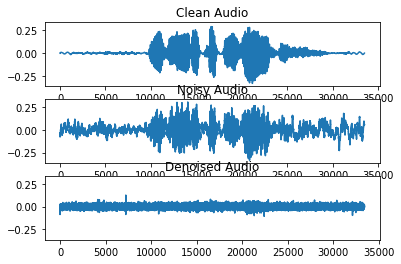

In [11]:
# plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")


In [12]:
import IPython.display as ipd
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=sample_rate) # load a local WAV file

In [13]:
ipd.Audio(data=cleanAudio, rate=sample_rate) # load a local WAV file

In [14]:
ipd.Audio(data=noisyAudio, rate=sample_rate) # load a local WAV file

In [15]:
# bose_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/proc.wav"
# boseAudio, sr = read_audio(bose_file, sample_rate)
# ipd.Audio(data=boseAudio, rate=sample_rate)